<a href="https://colab.research.google.com/github/Madhukiranchiti/RTML/blob/main/MLP_Assignment1_mk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Fashion and Housing Multi-layer Perceptron Model Training
## Course : Real-Time Machine Learning 5106
### Name : Lasya Vadlamudi
### Student ID : 801318796

In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.7 MB/s eta 0:00:00


In [2]:
class Train_Model: # A class to train and save the developed model and the metrics


    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):

        self.device = device
        self.model = model.to(device) ## Setting the model on GPU
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes

        # A dictionary to append or store the results
        self.Metrics = {"Training_Loss":[],"Training_Accuracy":[], "Validation_Loss":[], "Validation_Accuracy":[],"Test_Accuracy":0}
        self.ConfMatrix = None

    # Function to train the model
    def model_run(self, l_data,run_type):

        if run_type == 'train':
          self.model.train()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          # Iterates over the data
          for data, labels in tqdm(l_data):

              # transform data into one-hot vectors
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)


              self.optimizer.zero_grad()
              loss_value.backward()
              self.optimizer.step()


              # Set the predictions and labels back into integers for accuracy calculation
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              ##### Calculate Loss and accuracy
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Training_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Training_Accuracy"].append(acc / len(l_data))


        elif run_type == 'eval':
          self.model.eval()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          for data, labels in l_data:

              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              with torch.no_grad():
                  predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)

              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Validation_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Validation_Accuracy"].append(acc / len(l_data))


    def fit(self, t_data, v_data, EPOCHS):


        for i in range(EPOCHS):

            self.model_run(v_data,'eval')
            self.model_run(t_data,'train')

            print("Current Epoch:", i+1)
            print("Training_Loss:", self.Metrics["Training_Loss"][-1], " | Validation_Loss:", self.Metrics["Validation_Loss"][-1])
            if self.model_type == "Classification":
                print("Training_Accuracy:", self.Metrics["Training_Accuracy"][-1].item(), " | Validation_Accuracy:", self.Metrics["Validation_Accuracy"][-1].item())


    def Test_Model(self, testLoader):

        self.model.eval()

        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy

        predMax = torch.empty(0)
        labelMax = torch.empty(0)

        for data, labels in testLoader:

            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            with torch.no_grad():
                pred = self.model(data)

            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))

        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test_Accuracy"] = MCA(predMax, labelMax).item()




## Problem 1 Fashion Dataset

In [3]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

In [5]:
train_df = datasets.FashionMNIST(root="datasets", train=True, transform=train_transform,download=True)
test_df = datasets.FashionMNIST(root="datasets", train=False, transform=test_transform,download=True)

## Create Train and Test data
validNum = int(len(train_df) * 0.8)
train_df, valid_df = random_split(train_df, [validNum, len(train_df) - validNum])


100%|██████████| 26421880/26421880 [00:02<00:00, 10380468.79it/s]


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 191962.19it/s]


Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3643804.72it/s]


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20198575.30it/s]


Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



In [6]:
trainLoader = DataLoader(train_df, batch_size=256, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_df, batch_size=256, shuffle=True, num_workers=1)
testLoader = DataLoader(test_df, batch_size=256, shuffle=True, num_workers=1)

In [7]:
BaseModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(in_features= 256, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 64),
    nn.ReLU(),
    nn.Linear(in_features= 64, out_features= 10),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
base = copy.deepcopy(BaseModel)
baseline_model_generator = Train_Model(base, nn.CrossEntropyLoss(), torch.optim.SGD(base.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

### 1.a Train the model from scratch (with randomized parameters)

100%|██████████| 188/188 [00:14<00:00, 13.02it/s]

Current Epoch: 1
Training_Loss: 1.0218124950819827  | Validation_Loss: 2.300686410132875
Training_Accuracy: 0.6397162675857544  | Validation_Accuracy: 0.07922246307134628



100%|██████████| 188/188 [00:14<00:00, 13.13it/s]

Current Epoch: 2
Training_Loss: 0.4816226916427308  | Validation_Loss: 0.517884963370384
Training_Accuracy: 0.8274038434028625  | Validation_Accuracy: 0.8107179403305054



100%|██████████| 188/188 [00:13<00:00, 13.79it/s]

Current Epoch: 3
Training_Loss: 0.4224810183365294  | Validation_Loss: 0.42237846521621053
Training_Accuracy: 0.8473816514015198  | Validation_Accuracy: 0.8422446846961975



100%|██████████| 188/188 [00:13<00:00, 13.77it/s]

Current Epoch: 4
Training_Loss: 0.38458205854639094  | Validation_Loss: 0.41527238678424916
Training_Accuracy: 0.8591309189796448  | Validation_Accuracy: 0.8405171036720276



100%|██████████| 188/188 [00:15<00:00, 11.80it/s]

Current Epoch: 5
Training_Loss: 0.3557979293326114  | Validation_Loss: 0.3687671835118152
Training_Accuracy: 0.872005045413971  | Validation_Accuracy: 0.863774299621582



100%|██████████| 188/188 [00:14<00:00, 12.56it/s]

Current Epoch: 6
Training_Loss: 0.33454311765888906  | Validation_Loss: 0.3386938013929002
Training_Accuracy: 0.8790283799171448  | Validation_Accuracy: 0.8761597275733948



100%|██████████| 188/188 [00:15<00:00, 12.53it/s]

Current Epoch: 7
Training_Loss: 0.31342465018338345  | Validation_Loss: 0.3254040581114749
Training_Accuracy: 0.8870748281478882  | Validation_Accuracy: 0.8800944685935974



100%|██████████| 188/188 [00:14<00:00, 13.38it/s]

Current Epoch: 8
Training_Loss: 0.3005404346325296  | Validation_Loss: 0.32019091857240556
Training_Accuracy: 0.890305757522583  | Validation_Accuracy: 0.8814218640327454



100%|██████████| 188/188 [00:14<00:00, 12.78it/s]


Current Epoch: 9
Training_Loss: 0.28887814972945985  | Validation_Loss: 0.3259140823749786
Training_Accuracy: 0.8953274488449097  | Validation_Accuracy: 0.8781104683876038


100%|██████████| 188/188 [00:15<00:00, 11.87it/s]

Current Epoch: 10
Training_Loss: 0.27452838476350966  | Validation_Loss: 0.30756909447781583
Training_Accuracy: 0.9011873006820679  | Validation_Accuracy: 0.8857197165489197



100%|██████████| 188/188 [00:15<00:00, 11.92it/s]


Current Epoch: 11
Training_Loss: 0.26623942584116406  | Validation_Loss: 0.30735419595495184
Training_Accuracy: 0.9020567536354065  | Validation_Accuracy: 0.8823812007904053


100%|██████████| 188/188 [00:15<00:00, 12.33it/s]

Current Epoch: 12
Training_Loss: 0.25242836860583184  | Validation_Loss: 0.2923695739913494
Training_Accuracy: 0.9076762199401855  | Validation_Accuracy: 0.8903553485870361



100%|██████████| 188/188 [00:13<00:00, 13.87it/s]

Current Epoch: 13
Training_Loss: 0.24305399110976686  | Validation_Loss: 0.2921791999263966
Training_Accuracy: 0.9116522669792175  | Validation_Accuracy: 0.8909425139427185



100%|██████████| 188/188 [00:13<00:00, 13.45it/s]

Current Epoch: 14
Training_Loss: 0.23458124911214442  | Validation_Loss: 0.28214060943177405
Training_Accuracy: 0.9147019982337952  | Validation_Accuracy: 0.8936232924461365



100%|██████████| 188/188 [00:13<00:00, 13.76it/s]

Current Epoch: 15
Training_Loss: 0.22778560918696383  | Validation_Loss: 0.30329980146377644
Training_Accuracy: 0.9161731600761414  | Validation_Accuracy: 0.8884627819061279



100%|██████████| 188/188 [00:13<00:00, 13.71it/s]


Current Epoch: 16
Training_Loss: 0.21566059741568058  | Validation_Loss: 0.2926837361239372
Training_Accuracy: 0.9218319058418274  | Validation_Accuracy: 0.8930178880691528


100%|██████████| 188/188 [00:13<00:00, 13.57it/s]

Current Epoch: 17
Training_Loss: 0.20740753998781772  | Validation_Loss: 0.301610233301812
Training_Accuracy: 0.9255597591400146  | Validation_Accuracy: 0.8925278782844543



100%|██████████| 188/188 [00:13<00:00, 13.77it/s]


Current Epoch: 18
Training_Loss: 0.20196025929552444  | Validation_Loss: 0.2947906027448938
Training_Accuracy: 0.9267645478248596  | Validation_Accuracy: 0.894372820854187


100%|██████████| 188/188 [00:13<00:00, 13.70it/s]

Current Epoch: 19
Training_Loss: 0.19419734952773185  | Validation_Loss: 0.2949644216197602
Training_Accuracy: 0.9287726879119873  | Validation_Accuracy: 0.891696035861969



100%|██████████| 188/188 [00:13<00:00, 13.80it/s]

Current Epoch: 20
Training_Loss: 0.19301518080557914  | Validation_Loss: 0.29541836774095576
Training_Accuracy: 0.9293666481971741  | Validation_Accuracy: 0.8946377635002136



Test Accuracy: 0.8763999938964844 
Time to Train: 0:06:00.958311


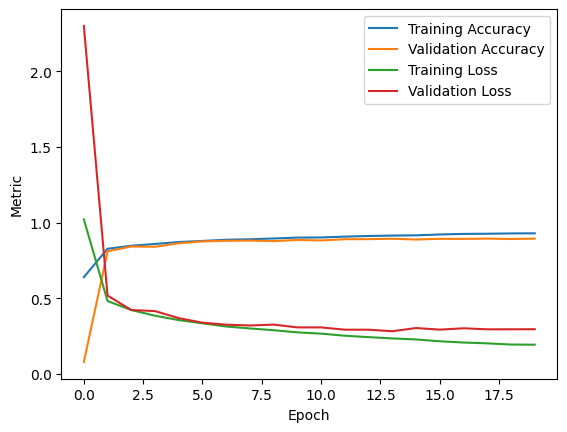

In [10]:
start_time = datetime.now()

baseline_model_generator.fit(trainLoader, validateLoader,
                             20)
end_time = datetime.now()
baseline_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", baseline_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(baseline_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(baseline_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(baseline_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(baseline_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

In [11]:
# Increased depth and width
ComplexModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
)
complex_model = copy.deepcopy(ComplexModel)


In [12]:
complex_m = copy.deepcopy(ComplexModel)
complex_model_generator = Train_Model(complex_m, nn.CrossEntropyLoss(), torch.optim.SGD(complex_m.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

In [13]:
start_time = datetime.now()

complex_model_generator.fit(trainLoader, validateLoader,
                             )
end_time = datetime.now()
complex_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", complex_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(complex_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(complex_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(complex_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(complex_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

TypeError: Train_Model.fit() missing 1 required positional argument: 'EPOCHS'

### Does your network need more epochs for full training? Do you observe overfitting?
We see that the validation loss hasn't shown any major change over the 20 epochs where as the training loss has reduced which means that the model is performing better on the training dataset but not the validation dataset resulting in overfitting.


## Problem 2 Housing Predictions

In [ ]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df = pd.read_csv("/content/datasets/Housing Data/train.csv")
test_df = pd.read_csv("/content/datasets/Housing Data/test.csv")
display(train_df.head()),display(test_df.head())

In [ ]:
def data_preprocessor_a(train_data, test_data, label='SalePrice'):

    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index

    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    #features_all = pd.get_dummies(features_all, dummy_na=True)

    train_df = features_all[:train_data.shape[0]].copy()

    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)

    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()

    return train_df, test_df


  def data_preprocessor_b(train_data, test_data, label='SalePrice'):

    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index

    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    features_all = pd.get_dummies(features_all, dummy_na=True)

    train_df = features_all[:train_data.shape[0]].copy()

    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)

    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()

    return train_df, test_df

In [ ]:
lectureModel = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)


class sale_predictor(nn.Module):
    def __init__(self):
        super(sale_predictor, self).__init__()

        # From output data
        self.mean = 180921.19589041095
        self.std = 79442.50288288662
        self.unNormalize = False
        self.Dropout = False
        self.D1 = nn.Dropout(0.3)

        self.layer1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.LazyLinear(256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.LazyLinear(128)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.LazyLinear(1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        if self.Dropout:
            x = self.D1(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)

        if self.unNormalize:
            x = x * self.std + self.mean

        return x

sale_predictor = sale_predictor()

In [ ]:
class housing_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        dimensions = torch.Tensor(row.values)
        label = dimensions[-1]

        return (dimensions[:-1], label)

2A

In [ ]:
train_processed_df, test_processed_df = data_preprocessor_a(train_df, test_df)
test_processed_df.head()

In [ ]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

2B


In [ ]:
train_processed_df, test_processed_df = data_preprocessor_b(train_df, test_df)
test_processed_df.head()

In [ ]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

### 2.c Improve the score by improving the model complexity

In [ ]:

LectureModel = copy.deepcopy(lectureModel)
LectureHousingTrainer = Train_Model(LectureModel, nn.MSELoss(), torch.optim.SGD(LectureModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

LectureHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(LectureHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(LectureHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

In [ ]:
base_housingModel = copy.deepcopy(sale_predictor)
ComplexHousingTrainer = Train_Model(base_housingModel, nn.MSELoss(), torch.optim.SGD(base_housingModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

ComplexHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(ComplexHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(ComplexHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### How about the model complexity comparison and training time?
The new model shows better accuracy compared to the model built during the class lectures.